# Classifier overview

This readme presents an overview of the current state of the classifier

In [11]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, plot_confusion_matrix, roc_auc_score, plot_roc_curve, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import yellowbrick.model_selection as ybms
from yellowbrick.classifier import precision_recall_curve

import json

import sys
sys.path.append('../')

from utils.cv_helpers import *
from utils.experiments import calculate_metrics, comparative_evaluation, get_mean_results

In [2]:
with open('../her2-status_config.json', 'r') as f:
    config = ast.literal_eval(f.read())

In [3]:
cv_scheme = RepeatedStratifiedKFold(n_splits=config['FOLDS'], n_repeats=config['REPEATS'], random_state=config['SEED'])

## Load data

In [4]:
X = pd.read_csv(config['TRAIN_DATA_FILE']).drop(['Tumour Average Depth', 'Normal Average Depth'], axis=1).set_index('sample_id')
y = pd.read_csv(config['Y_TRAIN_FILE']).set_index('sample_id').Class

X_holdout = pd.read_csv(config['HOLDOUT_DATA_FILE']).drop(['Tumour Average Depth', 'Normal Average Depth'], axis=1).set_index('sample_id')
y_holdout = pd.read_csv(config['Y_HOLDOUT_FILE']).set_index('sample_id').Class

Training data size: 613
Holdout data size: 263


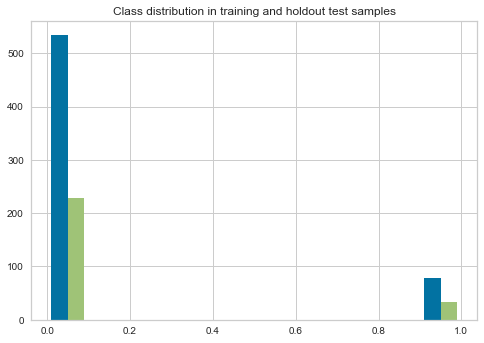

In [5]:
print('Training data size: {}'.format(X.shape[0]))
print('Holdout data size: {}'.format(X_holdout.shape[0]))

plt.hist([y, y_holdout]);
plt.title('Class distribution in training and holdout test samples');

## Selected model

In [18]:
clf = DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=1, min_samples_leaf=1, min_samples_split=2)

model = clf.fit(X, y)

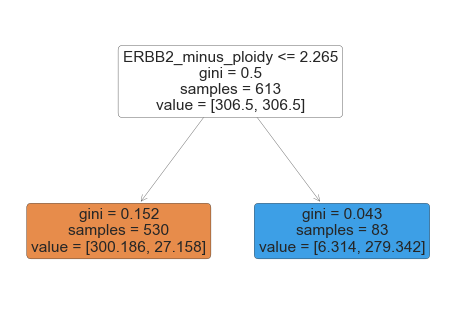

In [19]:
plot_tree(model,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          proportion=False
);

## Cross-validation performance on training data

In [20]:
print('Cross-validation scheme: {}-folds, {}-repeats'.format(config['FOLDS'], config['REPEATS']))

Cross-validation scheme: 3-folds, 10-repeats


In [21]:
results = comparative_evaluation({'Classifier': (X, y)}, {config['CLF_NAME']: clf}, positive_class=1, cv=cv_scheme, random_state=config['SEED'])

  0%|          | 0/30 [00:00<?, ?it/s]

In [22]:
cv_results = get_mean_results(results, by='Classifier')
cv_results

Value          
                                   mean       std
Classifier  Metric                               
her2-status AUC_ROC            0.933096  0.034482
            Accuracy           0.967870  0.012733
            Balanced accuracy  0.933096  0.034482
            F1                 0.929098  0.026985
            Kappa              0.858284  0.053872
            MCC                0.860123  0.052695
            Precision          0.872938  0.064924
            Recall             0.886230  0.069732

## Performance on training data without cross-validation

In [26]:
y_pred = model.predict(X)
y_prob = model.predict_proba(X)

train_results = calculate_metrics(y, y_pred, y_prob[:, 1])

train_results

,Accuracy,Precision,Recall,F1,AUC_ROC,Kappa,MCC,Balanced accuracy
1,0.97553,0.932432,0.873418,0.901961,0.932027,0.887998,0.888618,0.932027


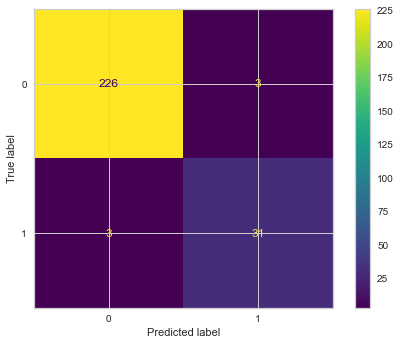

In [27]:
plot_confusion_matrix(model, X_holdout, y_holdout);

## Test set performance on holdout data

In [24]:
y_pred = model.predict(X_holdout)
y_prob = model.predict_proba(X_holdout)

holdout_results = calculate_metrics(y_holdout, y_pred, y_prob[:, 1])

holdout_results

,Accuracy,Precision,Recall,F1,AUC_ROC,Kappa,MCC,Balanced accuracy
1,0.977186,0.911765,0.911765,0.911765,0.949332,0.898664,0.898664,0.949332


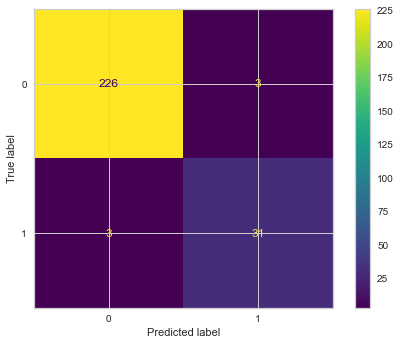

In [25]:
plot_confusion_matrix(model, X_holdout, y_holdout);